## Hierarchical Binominal Model: Rat Tumor Example

* 아직 `Potential` , `Deterministic` , `Stochastic` 에 대한 함수가 이해가 잘 안된다.
* `Potential` 은 먼가 기존에 정의했던 함수를 다른 식으로 바꿔서 사용 할 수 있게 해주는 느낌이긴 한데, 음...

In [13]:

%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3.distributions.transforms as tr
import theano.tensor as tt
from scipy.special import gammaln



plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))



Running on PyMC3 v3.6


* 설치류의 수는 binomial 분포

$y_i \sim Bin(\theta_i ; n_i) $ 

* 음 일단 다루기 쉬운 분포로 Beta분포로 

$ \theta_i \sim Beta(\alpha , \beta) $

* $\alpha, \beta$는 일단은 자유롭게 $p(\alpha, \beta) \propto (\alpha + \beta)^{-\frac{5}{2}}$

* 사후분포
$p(\alpha , \beta , \theta | y ) \propto p(\alpha \beta) p(\theta | \alpha , \beta)p(y | \theta) $

In [14]:
y = np.array([
     0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
     1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
     5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])

N = len(n)

In [15]:
def log_likelihood(alpha,beta,y,n):
    LL = 0

    #Summing over data
    for Y,N in zip(y,n):
        LL+= gammaln(alpha+beta) - gammaln(alpha) - gammaln(beta) + gammaln(alpha+Y) +gammaln(beta+N-Y) - gammaln(alpha+beta+N)

    return LL

def log_prior(A,B):

    return -5/2*np.log(A+B)

def trans_to_beta(x,y):

    return np.exp(y)/(np.exp(x)+1)

def trans_to_alpha(x,y):

    return np.exp(x)*trans_to_beta(x,y)

#Create space for the parameterization in which we wish to plot
X,Z = np.meshgrid(np.arange(-2.3,-1.3,0.01),np.arange(1,5,0.01))
param_space = np.c_[X.ravel(), Z.ravel()]
df= pd.DataFrame(param_space, columns=['X','Z'])

#Transform the space back to alpha beta to compute the log-posterior
df['alpha']= trans_to_alpha(df.X,df.Z)
df['beta'] = trans_to_beta(df.X,df.Z)

df['log_posterior'] = log_prior(df.alpha,df.beta) + log_likelihood(df.alpha,df.beta, y,n)
df['log_jacobian'] = np.log(df.alpha) + np.log(df.beta)

df['transformed'] = df.log_posterior+df.log_jacobian
df['exp_trans'] = np.exp(df.transformed - df.transformed.max())

#This will ensure the density is normalized
df['normed_exp_trans'] = df.exp_trans/df.exp_trans.sum()


surface = df.set_index(['X','Z']).exp_trans.unstack().values.T

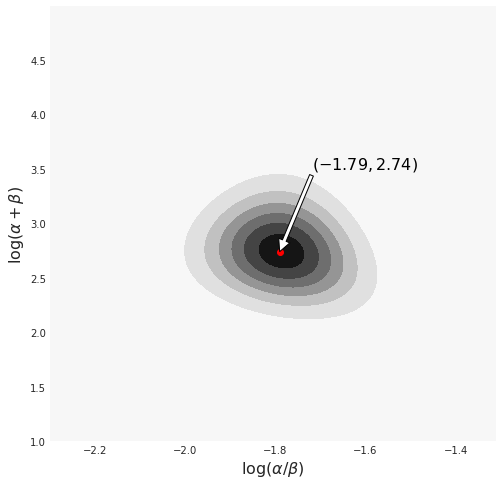

In [16]:
fig, ax = plt.subplots(figsize = (8,8))
ax.contourf(X,Z, surface)
ax.set_xlabel(r'$\log(\alpha/\beta)$', fontsize = 16)
ax.set_ylabel(r'$\log(\alpha+\beta)$', fontsize = 16)

ix_z,ix_x = np.unravel_index(np.argmax(surface, axis=None), surface.shape)
ax.scatter([X[0,ix_x]], [Z[ix_z,0]], color = 'red')

text= r"$({a},{b})$".format(a = np.round(X[0,ix_x],2), b = np.round(Z[ix_z,0],2))

ax.annotate(text,
            xy = (X[0,ix_x],Z[ix_z,0]),
            xytext=(-1.6, 3.5),
            ha = 'center',
            fontsize = 16,
            color = 'black',
            arrowprops=dict(
                            facecolor='white',

                            )
           );

In [18]:
#Estimated mean of alpha
(df.alpha*df.normed_exp_trans).sum().round(3)

2.403

In [19]:
#Estimated mean of beta
(df.beta*df.normed_exp_trans).sum().round(3)

14.319

## pymc3 를 사용하면 heirarchichal mode을 쉽게 만들 수 있다. 

* 사후분포
$p(\alpha , \beta , \theta | y ) \propto p(\alpha ,  \beta) p(\theta | \alpha , \beta)p(y | \theta) $

* pm.Potential
[document](http://pymc-devs.github.io/pymc/modelbuilding.html#the-potential-class)
[stackoverflow](https://stats.stackexchange.com/questions/251280/what-is-pm-potential-in-pymc3)
* The third basic class, `Potential`, represents ‘factor potentials’ ([Lauritzen1990],[Jordan2004]_), which are not variables but simply log-likelihood terms and/or constraints that are multiplied into joint distributions to modify them. Potential and Variable are subclasses of Node.
* `A Stochastic object` represents a variable whose value is not completely determined by its parents, 
* `a Deterministic object` represents a variable that is entirely determined by its parents. In object-oriented programming parlance, 
* `Stochastic` and `Deterministic` are subclasses of the Variable class, which only serves as a template for other classes and is never actually implemented in models.
* 이것들에 정의에 대해서 너무 헷갈린다....[예시](https://github.com/junpenglao/All-that-likelihood-with-PyMC3/blob/master/Notebooks/Normal_mixture_logp.ipynb) [예시2](https://github.com/pymc-devs/pymc3/blob/f9917a2b021dc84215ca0ea9ac2f88e0e7f34a74/pymc3/examples/factor_potential.py#L3-L8) [설명](https://discourse.pymc.io/t/difference-between-densitydist-and-potential/307)
* 여기서 보면 `Potential` 를 걸어주니 분포가 다르게 시각화가 된다.
* A `potential` allows you to add an arbitrary term to the logp function, without adding new variables to the model. 
* It is mostly a way to cheat your way around limitations of pymc3, where the current distributions don’t allow you to do what you want easily. 
* An example of this are some forms of truncation or censoring that aren’t supported directly atm.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4882.98draws/s]


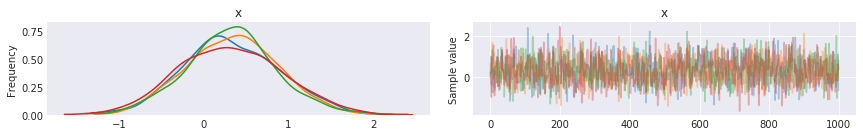

In [36]:
import pymc3 as pm

"""
You can add an arbitrary factor potential to the model likelihood using 
pm.Potential. For example you can added Jacobian Adjustment using pm.Potential
when you do model reparameterization. It's similar to `increment_log_prob` in 
STAN.
"""

def build_model():
    with pm.Model() as model:
        x = pm.Normal('x', 1, 1)
        x2 = pm.Potential('x2', -x ** 2)
    return model

def run(n=1000):
    model = build_model()
    if n == "short":
        n = 50
    with model:
        trace22 = pm.sample(n)
        pm.traceplot(trace22);

if __name__ == '__main__':
    run()
    

In [20]:
def logp_ab(value):
    ''' prior density'''
    return tt.log(tt.pow(tt.sum(value), -5/2))



with pm.Model() as model:
    # Uninformative prior for alpha and beta
    ab = pm.HalfFlat('ab',shape=2,testval=np.asarray([1., 1.]))
    pm.Potential('p(a, b)', logp_ab(ab))

    X = pm.Deterministic('X',tt.log(ab[0]/ab[1]))
    Z = pm.Deterministic('Z',tt.log(tt.sum(ab)))

    theta = pm.Beta('theta', alpha=ab[0], beta=ab[1], shape=N)

    p = pm.Binomial('y', p=theta, observed=y, n=n)
    trace = pm.sample(1000, tune=2000, nuts_kwargs={'target_accept': .95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, ab]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:26<00:00, 454.16draws/s]
The number of effective samples is smaller than 25% for some parameters.


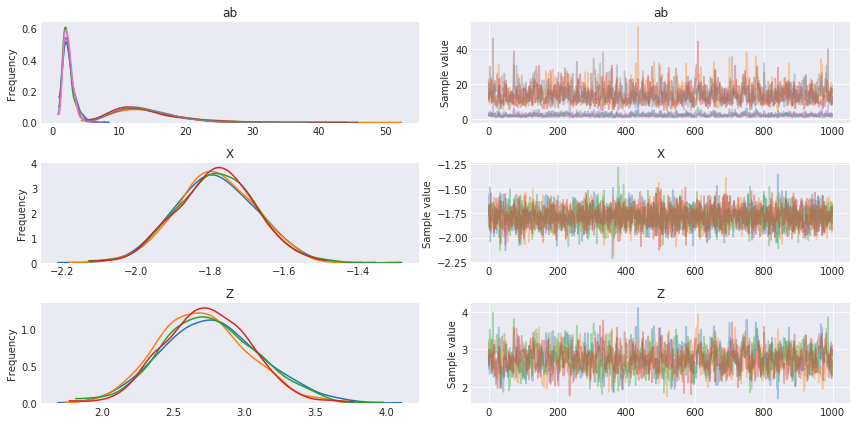

In [21]:
#Check the trace. Looks good!
pm.traceplot(trace, varnames=['ab','X','Z']);

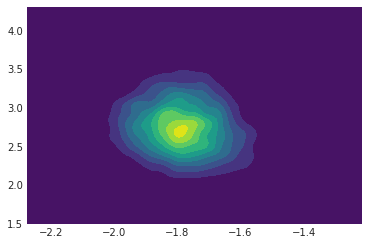

In [22]:
sns.kdeplot(trace['X'], trace['Z'],shade = True, cmap = 'viridis');

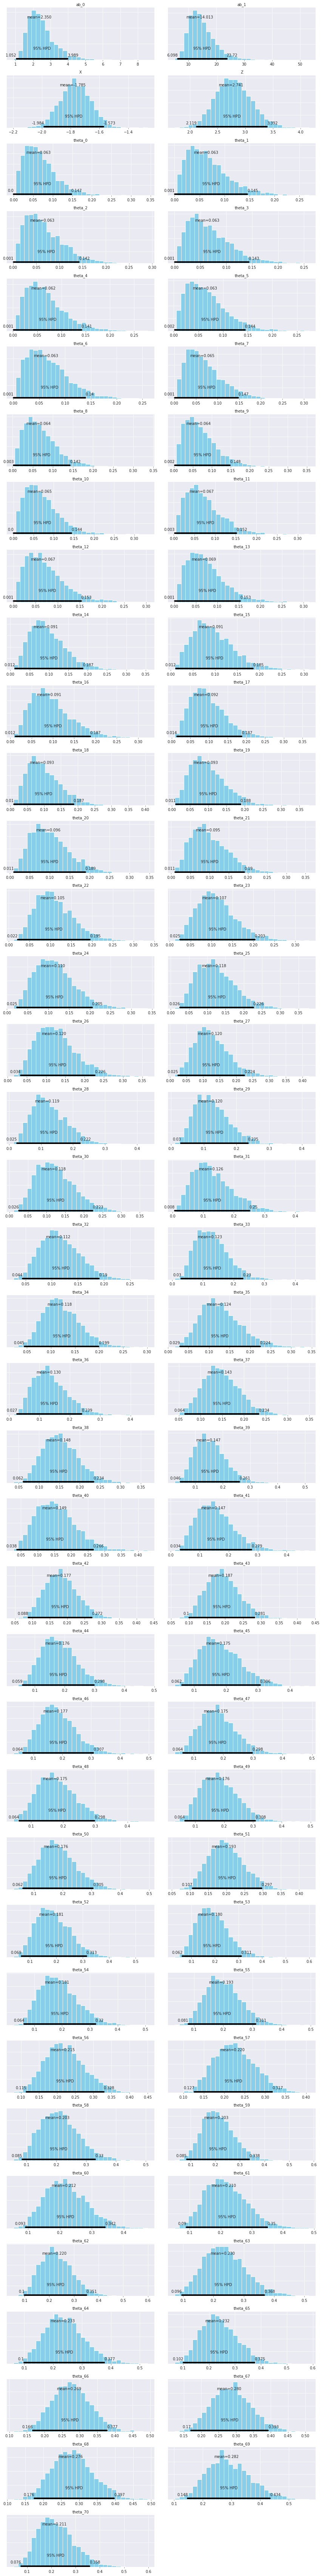

In [27]:
pm.posteriorplot.plot_posterior(trace);

In [24]:

#estimate the means from the samples
trace['ab'].mean(axis = 0)


array([ 2.34999528, 14.01278437])

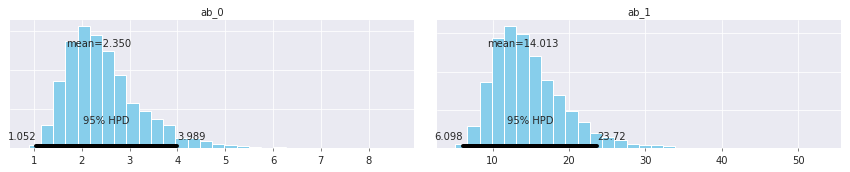

In [28]:
pm.posteriorplot.plot_posterior(trace, varnames = ['ab']);

## Conclusion

* 사후분포를 계산하는 것은 쉽지는 않지만, Pymc3에서는 쉽게 샘플링을 뽑아서 사후분포를 추정할 수 있습니다.